In [1]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 12)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.* from month_chart
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df1 = df1[df1["date"] == df1["date"].max()]  # date = date.max 아니면, 상장폐지 되는 종목. 매수일이 월말이기 때문에 매수 불가
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df2["date"] = df2["date"].max()  # date = date.max 아니면, 상장폐지 되는 종목. 정리매매 거치기 때문에 별도 처리 필요 없음.
    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지, 따라서 매수불가
    df1 = df1[df1["val_last"] > 1_000_0000]  # 거래량 일정 수준 이상(거래량 적을 시 매수 실패할거라고 가정)
    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "P": df1["cap"],
        "vol": df1["vol"],
        "val": df1["val"],
        "shares": df1["shares"],
        "avg": df1["avg"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1.to_csv(".cache/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

layer1 = pd.read_csv(".cache/layer1.csv", dtype={"code": str})
layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = '../res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1 = layer1[layer1["확정실적"].notna()]
layer1.shape

(207613, 55)

In [172]:
import numpy as np

layer2 = layer1.copy()


def add_factor(name, value):
    factors.append(name)
    layer2[name] = value


factors = ["P", "수익률", "val"]
factors += [col for col in layer1.columns if col.endswith("QoQ")]

add_factor("logP", np.ceil(np.log2(layer2["P"])))

# 가격비율
add_factor("EQ/P", layer2["EQ"] / layer2["P"])

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    add_factor(f"{col}/P", layer2[f"{col}/Y"] / layer2["P"])
    add_factor(f"{col}/A", layer2[f"{col}/Y"] / layer2["A"])  # 자산비율
    add_factor(f"{col}/EQ", layer2[f"{col}/Y"] / layer2["EQ"])  # 자본비율
    if col != "R":
        add_factor(f"{col}/R", layer2[f"{col}/Y"] / layer2["R/Y"])  # 이익율

add_factor("유동부채비율", layer1["유동부채"] / layer1["유동자산"])

# RECIPE ==========================================================

recipes = {
    "벨류": {
        "GP/P": 0.120550,
        "EQ/P": 0.105678,
    },
    "퀄리티": {
        "GP/A": 0.032862,
        "GP/EQ": 0.028487,
        "R/A": 0.012971,
        "GP/R": 0.012141,
        "O/A": 0.009835,
        "E/R": 0.005616,
        "EBT/A": 0.005415,
        "O/EQ": 0.005188,
        "O/R": 0.004577,
        "R/EQ": 0.004484,
        "EBT/R": 0.003881,
        "E/A": 0.003815,
        "EBT/EQ": 0.003162,
        "E/EQ": 0.002940
    },
    "성장": {
        "O_QoQ": 0.027,
        "E_QoQ": 0.024,
        "EBT_QoQ": 0.017,
        "O/A_QoQ": 0.013,
        "E/EQ_QoQ": 0.011,
        "O/EQ_QoQ": 0.01,
        "E/A_QoQ": 0.009,
        "EBT/A_QoQ": 0.008,
        "EBT/EQ_QoQ": 0.006,
        "GP/EQ_QoQ": 0.004,
        "GP/A_QoQ": 0.004,
        "GP_QoQ": 0.003,
        "R_QoQ": 0.001,
        "R/EQ_QoQ": 0.001,
        "R/A_QoQ": 0.001,
    },
    "가격": {
        "P": -1
    },
    "전략": {
        "성장": 1,
        "벨류": 1,
        "가격": 1
    },
}

# for k1 in ["R", "GP", "O", "EBT", "E"]:
#     recipes[k1 + "성장"] = {
#         k1 + k2 + "_QoQ": 1 for k2 in ["", "/A", "/EQ"]
#     }
# 
# for k1 in ["_QoQ", "/A_QoQ", "/EQ_QoQ"]:
#     recipes[k1 + "성장"] = {
#         k2 + k1: 1 for k2 in ["R", "GP", "O", "EBT", "E"]
#     }
# 
# recipes["신성장"] = {
#     "_QoQ성장": 1,
#     "O성장": 1
# }

# =================================================================

pct_scale = 10


def calc_pct_by_month(_col: str):
    grouped_by_month = layer2.groupby("매도년월")[_col]
    return grouped_by_month.apply(lambda x: np.ceil(x.rank(pct=True) * pct_scale)).reset_index(level=0, drop=True)


for factor in factors:
    layer2[f"{factor}_pct"] = calc_pct_by_month(factor)

for title, recipe in recipes.items():
    layer2[title] = layer2.apply(lambda row: sum([row[f"{k}_pct"] * w for k, w in recipe.items()]), axis=1)
    layer2[f"{title}_pct"] = calc_pct_by_month(title)

layer2.shape

(207613, 113)

In [176]:
import matplotlib.pyplot as plt

factor = "전략"

returns = layer2.groupby(factor + "_pct").apply(lambda x: x.groupby("매도년월")["수익률"].mean())
if type(returns) is pd.Series:
    returns = returns.to_frame().reset_index().pivot(index=factor + "_pct", columns="매도년월")
    returns = returns.droplevel(level=0, axis=1)

years = returns.columns.min().duration(returns.columns.max())
cagr_by_rank = returns.apply(lambda x: (x + 1).prod() ** (1 / years) - 1, axis=1)
corr_by_month = returns.apply(lambda x: x.corr(pd.Series(x.index)))

# plt.figure(figsize=(10, 6))
# plt.bar([str(month) for month in corr_by_month.index], corr_by_month.values)
# plt.xticks([str(x) for x in corr_by_month.index[::len(corr_by_month) // 8]])

(returns + 1).cumprod(axis=1)

매도년월,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
전략_pct,,,,,,,,,,,,,,,,,,,,,
1.0,0.990349,0.969199,0.965803,0.994729,0.972556,0.926303,0.927002,0.894220,0.931833,0.974289,...,0.539461,0.512330,0.520286,0.509091,0.524623,0.522207,0.474653,0.411471,0.467046,0.483003
2.0,0.953582,0.951824,0.959850,0.997556,1.017351,1.003428,0.973822,0.959912,1.024384,1.089559,...,1.029802,1.040352,1.055121,1.082166,1.087014,1.075160,0.997060,0.874602,0.955867,0.999315
3.0,0.986491,0.964406,0.968897,0.999713,1.009626,0.983653,0.964686,0.958052,1.006321,1.048311,...,0.908574,0.893015,0.915163,0.917173,0.893347,0.910739,0.843394,0.767896,0.845519,0.877376
4.0,0.993401,0.975037,0.989025,1.037726,1.041483,1.007780,0.991267,0.992708,1.077346,1.162313,...,1.850975,1.828170,1.897308,1.932371,1.903413,1.963710,1.869450,1.695260,1.825217,1.870499
5.0,0.989058,0.999437,1.013004,1.053906,1.066422,1.011734,0.997252,0.994310,1.062265,1.131430,...,1.791544,1.783422,1.843520,1.843256,1.751902,1.801226,1.724021,1.593958,1.696884,1.744330
6.0,1.011252,0.983251,0.991189,1.037057,1.060906,1.030646,1.015615,1.024356,1.107813,1.225369,...,2.455275,2.521154,2.591152,2.613725,2.504914,2.576270,2.430366,2.256869,2.448402,2.531758
7.0,0.993823,0.983770,0.999603,1.033552,1.046951,1.019256,1.003316,1.003247,1.081209,1.163384,...,2.869784,2.870452,2.987197,3.018826,2.867569,2.980433,2.807382,2.660597,2.866590,2.907942
8.0,1.013221,1.022495,1.051382,1.078495,1.085318,1.074416,1.088868,1.090154,1.176025,1.289546,...,5.781097,5.716953,5.983925,6.156672,5.803317,5.865561,5.559649,5.193053,5.571708,5.700439
9.0,1.021634,1.005927,1.040927,1.081950,1.100991,1.091728,1.096330,1.080772,1.203106,1.326598,...,7.006364,7.177407,7.611388,7.877648,7.442301,7.599556,7.309517,6.961888,7.552033,7.892086


[5/5] 전략티2014-04 2023-12


,strength,slope,spearman,pearson,t10,h10,t10-h10,mean,median
전략,3.758024,3.851391,0.975758,0.976564,0.100320,0.100320,0.0,0.100320,0.083894
가격,3.388931,3.856370,0.878788,0.821178,0.097292,0.097292,0.0,0.097292,0.040505
성장,1.599957,1.660333,0.963636,0.947131,0.096967,0.096967,0.0,0.096967,0.076612
벨류,1.430658,1.584286,0.903030,0.875954,0.095439,0.095439,0.0,0.095439,0.109666
퀄리티,0.019825,0.105519,0.187879,0.148441,0.095978,0.095978,0.0,0.095978,0.096965


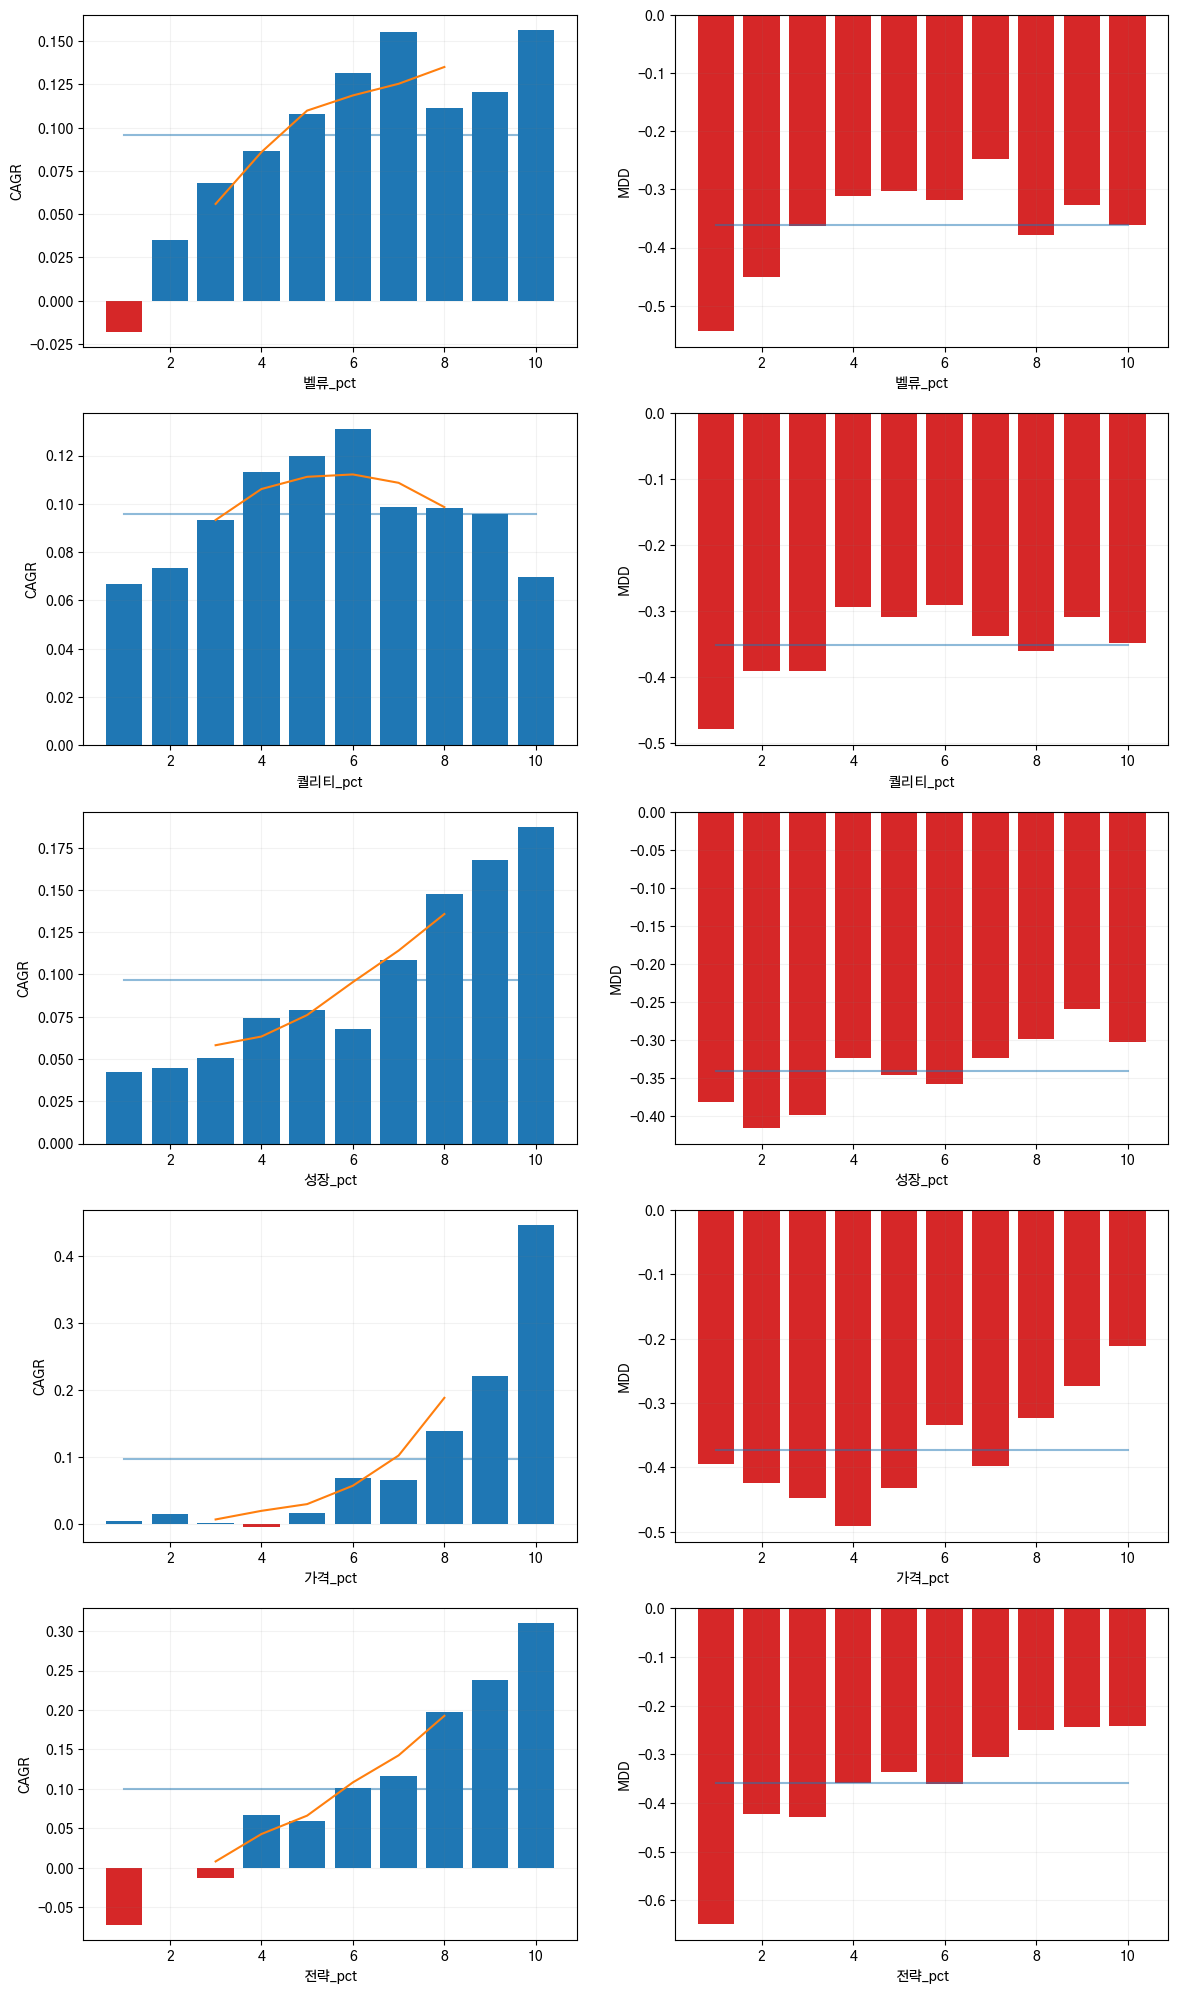

In [174]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr as calc_cagr
from utils.quantutil import mdd as calc_mdd
from utils import pdutil

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()

# 다시.. 그리고..
# mdd
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = layer2[colname].dropna().sort_values().unique()
    cagr, mdd = [], []
    for pct in pcts:
        by_pct = layer2[layer2[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        cagr.append(calc_cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd.append(calc_mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    pcts = pd.Series(pcts)
    cagr, mdd = pd.Series(cagr), pd.Series(mdd)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr, color=["tab:blue" if v > 0 else "tab:red" for v in cagr])
    ax1.plot(pd.Series(pcts), [cagr.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd, color=["tab:blue" if v > 0 else "tab:red" for v in mdd])
    ax2.plot(pd.Series(pcts), [mdd.mean() for _ in pd.Series(pcts)], alpha=0.5)

    pct_mean = pcts.mean()
    cagr_mean = cagr.mean()

    slope = sum((pcts - pct_mean) * (cagr * 100 - cagr_mean)) / sum((pcts - pct_mean) ** 2)
    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="spearman")
    pearson = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr()
    summary = pd.concat([
        summary,
        pd.Series({
            "slope": slope,
            "spearman": spearman[colname]["CAGR"],
            "pearson": pearson[colname]["CAGR"],
            "t10": cagr.tail(10).mean(),
            "h10": cagr.head(10).mean(),
            "t10-h10": cagr.tail(10).mean() - cagr.head(10).mean(),
            "mean": cagr.mean(),
            "median": cagr.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["slope"]

print(layer2["매수년월"].min(), layer2["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary = summary[pdutil.sort_columns(summary.columns, forward=["strength"])]
summary.to_csv(".cache/summary.csv")
summary

In [175]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = layer2.groupby(_key)["수익률"].mean()

strategy_name = "전략"
print(strategy_name)

result2 = layer2.copy()[layer2[strategy_name].notna()]

result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/R_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/R_pct"] > 10]
result2 = result2[result2["EBT/A_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["O/R_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["EBT/R_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["EBT/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

port_size = 20
port = result2.groupby(_key).apply(lambda x: x.sort_values(strategy_name, ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)

revisions.to_csv(".cache/revisions.csv")
revisions

전략


IndexError: single positional indexer is out-of-bounds

In [ ]:
result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "consolidated", f"{strategy_name}_pct"
]]
result3 = result3.reset_index(drop=True)
result3.to_csv(".cache/port.csv")
result3

In [ ]:
import numpy as np

months = [str(i) for _, i in revisions.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0.01).sum(),
    "under-perform": (revisions["성능"] < -0.01).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
plt.figure(figsize=(10, 6))
plt.plot(months, revisions["BM 누적수익률"])
plt.plot(months, revisions["전략 누적수익률"])

plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)